In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('styler.latex.hrules', True)
pd.set_option('styler.format.precision', 2) 

# Generic functions

In [56]:
def unhex_str(compressed_object : str):
    as_str = bytes.fromhex(compressed_object).decode('utf-8').replace('][', ' ').replace('[', '').replace(']', '')
    return [float(x) for x in as_str.split(' ')]

def separate_old_new_data(line : pd.core.series.Series, with_nan=True):
    old_data = list()
    new_data = list()
    for real_data, old_iteration, new_iteration in zip(line['realdata_uncompressed'], line['predictold_uncompressed'], line['predictnew_uncompressed']):
        if not math.isnan(float(old_iteration)):
            old_data.append(float(real_data))
            if with_nan: new_data.append(float('nan'))
        elif not math.isnan(float(new_iteration)):
            if with_nan: old_data.append(float('nan'))
            new_data.append(float(real_data))
    return old_data, new_data        

def plot_for_line(line : pd.core.series.Series, ax : matplotlib.axes._axes.Axes = None):
    if ax is None:
        fig, ax =  plt.subplots(1, 1, figsize=(8, 4), layout='constrained')
    ax.plot(line['realdata_uncompressed'], color='grey',  linestyle='-.',  alpha=0.4)
    ax.plot(line['predictold_uncompressed'])
    ax.plot(line['predictnew_uncompressed'])
    #plt.xlabel('Ticks')
    stable_str = '(stable)' if line['stable'] else '(unstable)'
    ax.set_title('n° ' + str(line['iteration']+3) + ' ' + stable_str)
    # +3 as there is no LSTM on first rounds [0:3]
    if line['metric'] == 'cpu_usage':
        ax.set_ylabel('Cores used')
    else:
        ax.set_ylabel('Memory used (MB)')

def plot_lstm_cpu(from_index : int = 0):
    from_index*=2
    if from_index%2 != 0:
        from_index = from_index+1
    to_index = from_index+(9*2)
    
    fig, axs = plt.subplots(3, 3, figsize=(10, 6), layout='constrained')
    for ax, line in zip(axs.flat, list(range(from_index, to_index, 2))):
        plot_for_line(line=trace_df.iloc[line], ax=ax)
        
def plot_lstm_mem(from_index : int = 0):
    from_index*=2
    if from_index%2 != 1:
        from_index = from_index+1
    to_index = from_index+(9*2)
    
    fig, axs = plt.subplots(3, 3, figsize=(10, 6), layout='constrained')
    for ax, line in zip(axs.flat, list(range(from_index, to_index, 2))):
        plot_for_line(line=trace_df.iloc[line], ax=ax)

# Load traces

In [42]:
location = '/usr/local/src/scroogevm/dump-decrease/dump-lstm.csv' # Adapt the location

trace_df = pd.read_csv(location, index_col=False, delimiter='\t')

# Apply a 1% threshold (can be changed)
trace_df['threshold'] = trace_df['config'].apply(lambda config : config*0.01)

trace_df['stable'] = trace_df.apply(lambda row : True if row['gap'] < row['threshold'] else False, axis=1)
trace_df['realdata_uncompressed'] = trace_df['realdata'].apply(lambda row : unhex_str(row))
trace_df['predictold_uncompressed'] = trace_df['predictold'].apply(lambda row : unhex_str(row))
trace_df['predictnew_uncompressed'] = trace_df['predictnew'].apply(lambda row : unhex_str(row))

print("Reading of LSTM traces completed successfully!")

Reading of LSTM traces completed successfully!


# Build Graphs

Observed data can be seen in generated graphs from the blue color. Orange curve shows the model prediction on historical data. Green curve shows the model prediction on the latest data. Average mispredict from both prediction is retrieved to compute a delta. If a delta exceeds a threshold, the model is considered as unstable

In [ ]:
line_number = 32
plot_for_line(trace_df.iloc[line_number])
x = plt.title('CPU traces on iteration n°' + str(trace_df.iloc[line_number]['iteration']))
if trace_df.iloc[line_number]['stable']:
    print('Considered stable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '<', trace_df.iloc[line_number]['threshold'], '(threshold)')
else:
    print('Considered unstable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '>=', trace_df.iloc[line_number]['threshold'], '(threshold)')

In [ ]:
line_number = 1
plot_for_line(trace_df.iloc[line_number])
x = plt.title('Memory traces on iteration n°' + str(trace_df.iloc[line_number]['iteration']))
if trace_df.iloc[line_number]['stable']:
    print('Considered stable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '<', trace_df.iloc[line_number]['threshold'], '(threshold)')
else:
    print('Considered unstable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '>=', trace_df.iloc[line_number]['threshold'], '(threshold)')

CPU traces on multiple iterations displayed:


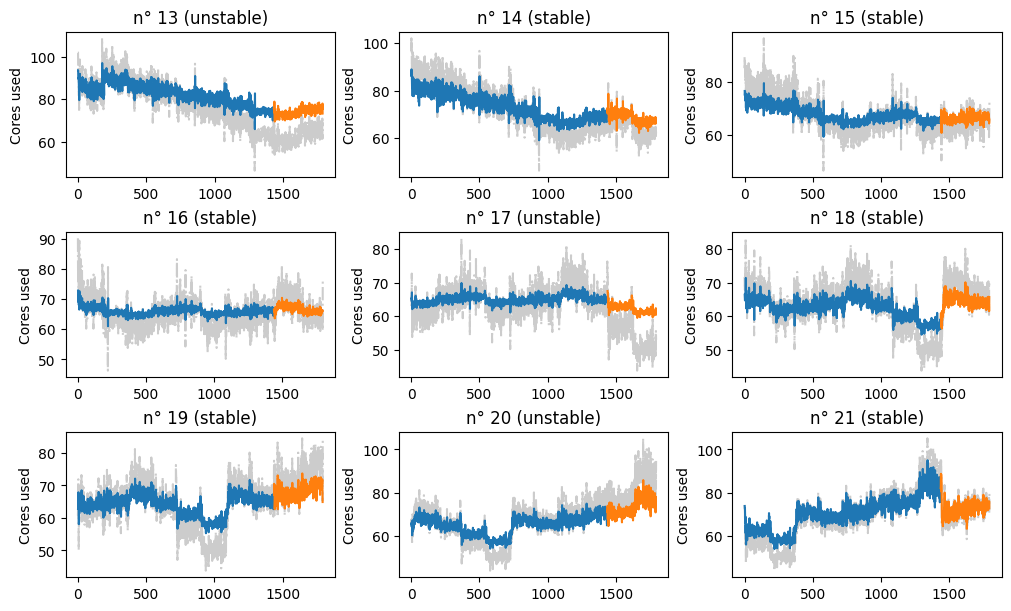

In [44]:
plot_lstm_cpu(from_index=9)
print('CPU traces on multiple iterations displayed:')

# Experiments on quiescent detection v1

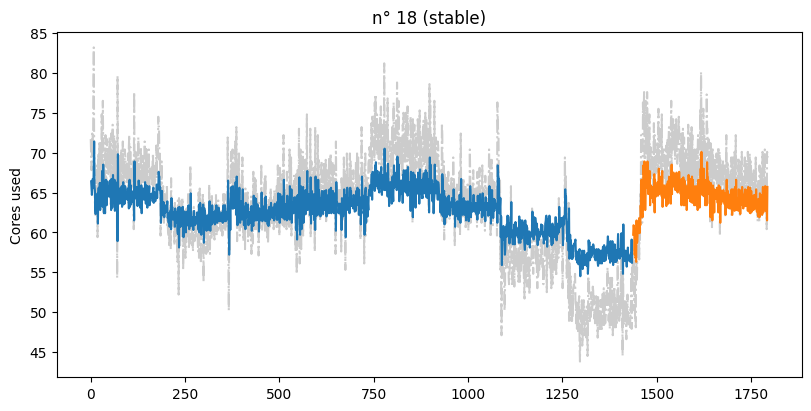

In [49]:
plot_for_line(trace_df.iloc[28])

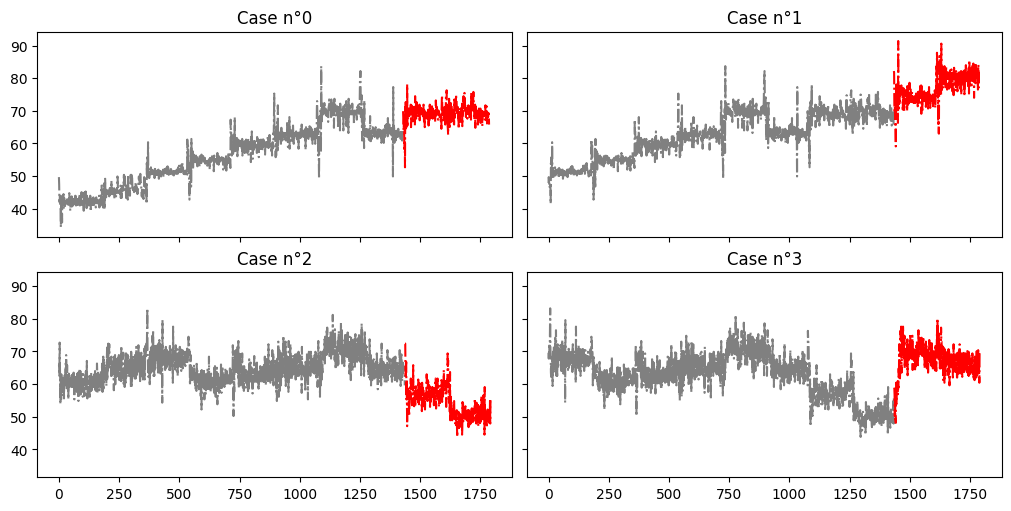

In [57]:
interesting_lines = pd.read_csv('save/interesting_lines.csv')
interesting_lines['realdata_uncompressed'] = interesting_lines['realdata'].apply(lambda row : unhex_str(row))
interesting_lines['predictold_uncompressed'] = interesting_lines['predictold'].apply(lambda row : unhex_str(row))
interesting_lines['predictnew_uncompressed'] = interesting_lines['predictnew'].apply(lambda row : unhex_str(row))

fig, axs = plt.subplots(2, 2, figsize=(10, 5), layout='constrained', sharex=True, sharey=True)
for ax, index in zip(axs.flat, range(len(interesting_lines))):
    old_data, new_data = separate_old_new_data(interesting_lines.iloc[index])
    ax.plot(old_data, color='grey',  linestyle='-.')
    ax.plot(new_data, color='red',  linestyle='-.')
    ax.set_title('Case n°' + str(index))

In [4]:
from model.stability_assesser.stabilityassesseraveragethreshold import StabilityAssesserAverageThreshold
from model.stability_assesser.stabilityassesserpercentilethreshold import StabilityAssesserPercentileThreshold
from model.stability_assesser.stabilityassesserpvalue import StabilityAssesserPValue
from model.stability_assesser.stabilityassesserlstm import StabilityAssesserLstm

assesser_avg  = StabilityAssesserAverageThreshold()
assesser_per  = StabilityAssesserPercentileThreshold()
assesser_pval = StabilityAssesserPValue()
assesser_lstm = StabilityAssesserLstm()

In [23]:
assessers_res = dict()
assessers_res['test_case']     = list()
assessers_res['assesser_avg']  = list()
assessers_res['assesser_per']  = list()
assessers_res['assesser_pval'] = list()
assessers_res['assesser_lstm'] = list()

for index in range(len(interesting_lines)):

    old_data_raw = json.loads(bytes.fromhex(trace_df.iloc[6]['inputold']).decode('utf-8'))
    new_data_raw = json.loads(bytes.fromhex(trace_df.iloc[6]['inputnew']).decode('utf-8'))
    
    assessers_res['test_case'].append(index)
    assessers_res['assesser_avg'].append(assesser_avg.assess(old_data=old_data, new_data=new_data, threshold_inf=1, threshold_sup=1))
    assessers_res['assesser_per'].append(assesser_per.assess(old_data=old_data, new_data=new_data, threshold_inf=0.9, threshold_sup=1.1))
    assessers_res['assesser_pval'].append(assesser_pval.assess(old_data=old_data, new_data=new_data, threshold=0))
    assessers_res['assesser_lstm'].append(assesser_lstm.assess(old_data=old_data, new_data=new_data, threshold=0.01, max_config=256, debug=True))

assesser_res_df = pd.DataFrame(assessers_res)

KeyError: 'inputold'

In [ ]:
assesser_res_df.head()

# Experiments on quiescent detection v2

## Experiments

In [ ]:
number_of_val = 67
dataset_list = list()

In [ ]:
fig, axs = plt.subplots(int(number_of_val/3)+1, 3, figsize=(10, int(number_of_val/3)), layout='constrained')

for ax, index in zip(axs.flat, list(range(1, number_of_val+1,1))):
    df = pd.read_csv('/usr/local/src/TSB-UAD/TSB-UAD-Public/YAHOO/Yahoo_A1real_' + str(index) + '_data.out', header=None)

    values = list(df[0])
    timestamp = list(range(len(values)))
    mid_index = int(len(values)/2)
    test_case = dict()
    test_case['old_val']  = values[:mid_index]
    test_case['old_tmst'] = timestamp[:mid_index] 
    test_case['new_val']  = values[mid_index:]
    test_case['new_tmst'] = timestamp[mid_index:]
    dataset_list.append(test_case)

    ax.plot(test_case['old_tmst'], test_case['old_val'], color='grey')
    ax.plot(test_case['new_tmst'], test_case['new_val'], color='red')
    ax.set_title('n°' + str(index))
    
    anomalies = df.loc[df[1] == 1]
    for index, row in anomalies.iterrows():
        ax.plot(float(index), float(row[0]), 'b+', mew=4, ms=3)

In [ ]:
from model.stability_assesser.stabilityassesseraveragethreshold import StabilityAssesserAverageThreshold
from model.stability_assesser.stabilityassesserpercentilethreshold import StabilityAssesserPercentileThreshold
from model.stability_assesser.stabilityassesserpvalue import StabilityAssesserPValue
from model.stability_assesser.stabilityassesserlstm import StabilityAssesserLstm

assesser_avg  = StabilityAssesserAverageThreshold()
assesser_per  = StabilityAssesserPercentileThreshold()
assesser_pval = StabilityAssesserPValue()
assesser_lstm = StabilityAssesserLstm()

In [ ]:
assessers_res = dict()
assessers_res['test_case']     = list()
assessers_res['assesser_avg']  = list()
assessers_res['assesser_per']  = list()
assessers_res['assesser_pval'] = list()
assessers_res['assesser_lstm'] = list()

for index, test_case in enumerate(dataset_list):
    
    assessers_res['test_case'].append(index)
    assessers_res['assesser_avg'].append(assesser_avg.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], threshold=5))
    assessers_res['assesser_per'].append(assesser_per.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], percentile=90, threshold=0.1))
    assessers_res['assesser_pval'].append(assesser_pval.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], threshold=0.1))
    assessers_res['assesser_lstm'].append(assesser_lstm.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], threshold=0.1))
    
    if (index%9) == 0: print(index+1, "done")
print("Task completed!")

In [ ]:
assessers_res_df = pd.DataFrame(assessers_res)
assessers_res_df.head()

In [ ]:
fig, axs = plt.subplots(int(number_of_val/3)+1, 3, figsize=(10, int(number_of_val/3)), layout='constrained')

test_case_index=0
for ax, test_case, res_avg, res_per, res_pval, res_lstm\
    in zip(axs.flat, dataset_list, assessers_res['assesser_avg'], assessers_res['assesser_per'],  assessers_res['assesser_pval'], assessers_res['assesser_lstm']):
    
    test_case_index+=1
    ax.plot(test_case['old_tmst'], test_case['old_val'], color='grey')
    ax.plot(test_case['new_tmst'], test_case['new_val'], color='red')
    
    assesser_res = ' : '
    assesser_res+= '-' if res_avg  else 'U'
    assesser_res+= '-' if res_per  else 'U'
    assesser_res+= '-' if res_pval else 'U'
    assesser_res+= '-'  if res_lstm else 'U'
    
    ax.set_title('n°' + str(test_case_index) + assesser_res)

## Find optimal parameter

In [ ]:
threshold=10
target = int(len(dataset_list)/2)
while True:
    #print("Testing threshold", threshold)
    count=0
    for test_case in dataset_list:
        result = assesser_avg.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], threshold=threshold)
        if not result: count+=1
    if result>=target:
        print("Threshold found with:", threshold, count)
        break
    threshold-=0.001
    if threshold<0:
        print("No threshold found 0:", count)
        break

In [ ]:
threshold=1
target = int(len(dataset_list)/2)
while True:
    #print("Testing threshold", threshold)
    count=0
    for test_case in dataset_list:
        result = assesser_per.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], threshold=threshold)
        if not result: count+=1
    if result>=target:
        print("Threshold found with:", threshold, count)
        break
    threshold-=0.001
    if threshold<0:
        print("No threshold found 0:", count)
        break

In [ ]:
threshold=1
target = int(len(dataset_list)/2)
while True:
    #print("Testing threshold", threshold)
    count=0
    for test_case in dataset_list:
        result = assesser_pval.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], threshold=threshold)
        if not result: count+=1
    if result>=target:
        print("Threshold found with:", threshold, count)
        break
    threshold-=0.001
    if threshold<0:
        print("No threshold found 0:", count
        break

In [ ]:
threshold=1
target = int(len(dataset_list)/2)
while True:
    #print("Testing threshold", threshold)
    count=0
    for test_case in dataset_list:
        result = assesser_lstm.assess(old_data=test_case['old_val'], new_data=test_case['new_val'], threshold=threshold)
        if not result: count+=1
    if result>=target:
        print("Threshold found with:", threshold, count)
        break
    threshold-=0.001
    if threshold<0:
        print("No threshold found 0:", count
        break